# Diversity analysis


In [13]:
import os
import pandas as pd
from qiime2 import Visualization
import matplotlib.pyplot as plt
import numpy as np

import qiime2 as q2

%matplotlib inline
data_dir = 'CE'

Artifacts used for alpha-diversity (start)
- dada2_table_align_filtered.qza
- fasttree-tree-rooted.qza
- sepp-tree.qza

## Alpha rarefaction

Which tree should be chosen to conduct alpha rarefaction? the de-novo tree or fragment insertion tree? 
-> fragment insertion tree was chosen, das we have rather short sequences which might not bring up enough information.
Artifacts of both trees are visualized here:

In [5]:
#denovo
Visualization.load(f'{data_dir}/fasttree-tree-rooted.qzv')

<visualization: Visualization uuid: b6ee1af1-07cb-475d-af95-50e410c824c5>

In [4]:
#fragment-insertion
Visualization.load(f'{data_dir}/sepp-tree-placements-tree.qzv')

<visualization: Visualization uuid: d319a4a0-e033-4c58-b7a1-f66f367940f7>

Using alpha-rarefaction we can decide which rarefying threshold is best suited for our data.
1. downloaded metadata (somehow wasn't in my CE). if you already have it run normally, if not, remove the hashtags # in the following two cells.
2. visualized diversity alpha-rarefaction (--p-max-depth 10000) to find out which sequencing depth to use -> 1500. Also no difference was noticed between de novo and fragment insertion tree. at the end we used the insertion tree.
3. use core-metrics-phylogenetic plugin
4. use diversity alpha-group-significance to run some statisical tests
5. use diversity alpha-correlation to check for correlations (columns - richness of microbial community)
6. some fun with pandas. nice poxplots

In [14]:
#! wget -nv -O $data_dir/food-metadata.tsv 'https://polybox.ethz.ch/index.php/s/nEd4l5CWGWGEtae/download'

2022-11-06 10:26:22 URL:https://polybox.ethz.ch/index.php/s/nEd4l5CWGWGEtae/download [42810/42810] -> "CE/food-metadata.tsv" [1]


In [15]:
#df_meta = pd.read_csv(f'{data_dir}/food-metadata.tsv', sep='\t', index_col=0)

In [20]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/dada2_table_align_filtered.qza \
    --i-phylogeny $data_dir/fasttree-tree-rooted.qza \
    --p-max-depth 100000 \
    --m-metadata-file $data_dir/food-metadata.tsv\
    --o-visualization $data_dir/alpha-rarefaction_denovo.qzv

Saved Visualization to: CE/alpha-rarefaction_denovo.qzv


In [21]:
#denovo tree: number of samples has plateau at around 7000 for rind-type
#could change --p-max-depth 7000 \
Visualization.load(f'{data_dir}/alpha-rarefaction_denovo.qzv')

<visualization: Visualization uuid: d3bffc94-08d3-4c2b-a593-28947694ee89>

In [29]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/dada2_table_align_filtered.qza \
    --i-phylogeny $data_dir/sepp-tree.qza \
    --p-max-depth 100000 \
    --m-metadata-file $data_dir/food-metadata.tsv\
    --o-visualization $data_dir/alpha-rarefaction_insertion.qzv

Saved Visualization to: CE/alpha-rarefaction_insertion.qzv


In [30]:
#fragment insertion tree: number of samples has plateau at around 7000 for rind-type
#could change --p-max-depth  7000\
Visualization.load(f'{data_dir}/alpha-rarefaction_insertion.qzv')

<visualization: Visualization uuid: 451f3775-a4b4-4ef5-85a2-fc702c1dceea>

Observation: no difference was found for denovo vs fragment insertion tree.
I would cut at 1500 and choose that as sequencing depth. The plateau is already reched for almost all fators then and the number of samples starts decreasing. With 1500 we don't loose too much. It could even be set lower, at around 1250.

at 1500: X samples are left (loose X samples)

Sequencing depth of 1500 for rarefaction: now let's have a look at the whitin-sample diversity (= alpha div.) Done for fragment-insertion tree.

In [28]:
! qiime diversity core-metrics-phylogenetic \
  --i-table $data_dir/dada2_table_align_filtered.qza \
  --i-phylogeny $data_dir/sepp-tree.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --p-sampling-depth 1500 \
  --output-dir $data_dir/core-metrics-results_insertion_1500

Saved FeatureTable[Frequency] to: CE/core-metrics-results_insertion_1500/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_1500/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_1500/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_1500/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_1500/evenness_vector.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_1500/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_1500/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_1500/jaccard_distance_matrix.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_1500/bray_curtis_distance_matrix.qza
Saved PCoAResults to: CE/core-metrics-results_insertion_1500/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: CE/co

In [31]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_1500/faith_pd_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_1500/faith-pd-group-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_1500/faith-pd-group-significance.qzv


In [32]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_1500/faith-pd-group-significance.qzv')

<visualization: Visualization uuid: 2c220be3-af8d-49c2-8801-f85eafd6f965>

In [33]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_1500/faith_pd_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_1500/faith-pd-group-significance-numeric.qzv

Saved Visualization to: CE/core-metrics-results_insertion_1500/faith-pd-group-significance-numeric.qzv


In [35]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_1500/faith-pd-group-significance-numeric.qzv')

<visualization: Visualization uuid: da1e033f-63d9-446a-9a53-6dede6846e02>

I feel like this correlation thing isn't necessary....
->> should try ANOVA q2-longitudinal? are assumptions correct tho?

#### PANDAS fun

In [36]:
art = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_1500/faith_pd_vector.qza')).view(pd.Series)
md = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['rindtype']

In [37]:
pd.concat([art, md], join = 'inner', axis = 1)

,faith_pd,rindtype
11488.CSB280,7.871464,natural
11488.CSB281,9.355944,natural
11488.CSB282,7.693184,natural
11488.CSB290,4.404400,washed
11488.CSB291,3.725973,washed
...,...,...
11488.CSB980,3.250105,natural
11488.CSB981,4.410405,natural
11488.CSB984,8.096717,natural
11488.CSB985,7.938898,washed


In [40]:
#no change, same rows and columns
artmd = pd.concat([art, md], join = 'inner', axis = 1).dropna()

Text(0.5, 0, 'Rind Type')

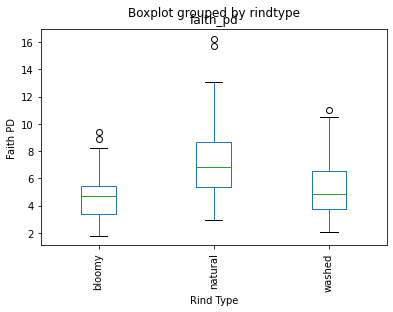

In [44]:
# make a boxplot with Faith PD on the y-axis and "sample_type" on the x-axis (hint: look at the "by" parameter)
artmd.boxplot(by = 'rindtype', rot=90, grid = False)
plt.ylabel('Faith PD')
plt.xlabel('Rind Type')

## Diversity analysis

## Alpha diversity

## Beta diversity

Analyse beta diversity from core-metrics-phylogenetic action:

Measure beta diversity in q2-diversity with the beta method. This method gives access to a wider selection of distance metrics than those used by core-metrics-phylogenetic.

In [6]:
! qiime diversity beta-correlation --help

Usage: qiime diversity beta-correlation [OPTIONS]

  Create a distance matrix from a numeric metadata column and apply a two-
  sided Mantel test to identify correlation between two distance matrices.
  Actions used internally: `distance-matrix` from q2-metadata and `mantel`
  from q2-diversity.

Inputs:
  --i-distance-matrix ARTIFACT
    DistanceMatrix     Matrix of distances between pairs of samples.
                                                                    [required]
Parameters:
  --m-metadata-file METADATA
  --m-metadata-column COLUMN  MetadataColumn[Numeric]
                       Numeric metadata column from which to compute pairwise
                       Euclidean distances                          [required]
  --p-method TEXT Choices('spearman', 'pearson')
                       The correlation test to be applied in the Mantel test.
                                                         [default: 'spearman']
  --p-permutations INTEGER
    Range(0, None)     The num

In [ ]:
! qiime diversity beta-correlation
  --i-distance-matrix 
  --m-metadata-file $data_dir/food-metadata.tsv \
  --m-metadata-column
  --o-metadata-distance-matrix $data_dir/beta-div-distance-matrix.qza \
  --o-mantel-scatter-visualization $data_dir/beta-div-mantel-scatter-vis.qzv 